In [ ]:
## Charger les donnés a partir du drive ou d'un dossier local
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%%capture
!pip install crewai

In [2]:
from crewai import Crew, Task, Agent, LLM
import pandas as pd
import numpy as np
from google.colab import userdata
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [3]:
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY') # Groq key
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')

In [4]:
groq_llama_3 = LLM(
    model='groq/llama3-70b-8192',
    temperature=0.7
)
groq_llama = LLM(
    model = "groq/llama-3.3-70b-versatile",
    #model = "groq/lama3-8b-8192",
    temperature=0.9
)

groq_mixtral = LLM(
    model = "groq/mixtral-8x7b-32768",
    temperature=0.9
)

gemini = LLM(
    #model='gemini/gemini-1.5-flash',
    model = 'gemini/gemini-2.0-flash-exp',
    temperature=0.7
)

In [37]:
# Agent 1: Générateur de clients et comportements
client_behavior_agent = Agent(
    role="Client and Behavior Generator",
    goal="Définir des comportements de clients pour des transactions bancaires effectué avec une carte et \
    de générer des clients avec leurs codes clients et leurs numéro de comptes.",
    backstory="Expert en segmentation de clients et modélisation des comportements transactionnels.",
    verbose=True,
    max_rpm=3,
    max_iter=5,
    cache=True,
    #llm=groq_llama_3
    llm=groq_llama
)

In [38]:
# Agent 2: Générateur de transactions normales
transaction_generator_agent = Agent(
    role="Normal Bank Transaction Generator",
    goal="Générer des transactions bancaires normales en fonction des comportements et des clients décrits par l'agent 'Client and Behavior Generator'",
    backstory="Expert en génération de données bancaires synthétiques pour modéliser des transactions réalistes.",
    verbose=True,
    max_rpm=3,
    max_iter=5,
    cache=True,
    llm=groq_llama
)

In [39]:
# Agent 3: Générateur de transactions frauduleuses
fraud_transaction_generator_agent = Agent(
    role="Fraudulent Bank Transaction Generator",
    goal="Simuler des transactions frauduleuses basées sur des comportements anormaux des clients décrits par l'agent 'Client and Behavior Generator'",
    backstory="Spécialiste en simulation d'observations de fraude bancaire.",
    verbose=True,
    max_rpm=3,
    max_iter=5,
    cache=True,
    llm=gemini
    #llm = groq_llama_3
)

In [40]:
generate_clients_task = Task(
    name="Generate Clients and Behaviors",
    agent=client_behavior_agent,
    description= "Définissez différents catégories de clients (au max 4) avec leurs comportements de transactions bancaire normales effectué avec une "
    "carte par des utilisateurs sénégalais. C'est à dire les fréquences habituels, montants (en FCFA : il commence de 1 000 à des millions) habituels ou "
    "moyen, intervalles des montants de transaction ( ex : 1 000 - 500 000, 1 000 - 2 000 000, 1 000 - plus de 2 000 000, ...), localisation habituels "
    "(partout au Sénégal: les client peuvent avoir plus de 10 lieux habituels ou faire leurs transactions dans tous les régions), types de transactions "
    "habituels (ATM, Paiement en ligne, Paiement électronique : les clients peuvent avoir l'habitude d'utiliser tous les 3 ou 2 types de transactions), horaires habituels "
    "(ex : 8H-19H)... Ne vous basez pas sur ses comportements seulement, cherchez sur internet pour améliorer ses comportements avec des comportements "
    "existants pour une meilleur modélisation des comportements transactionnels. Après cela, simulez {n} clients c'est à dire {n} codes clients et {n} "
    "numéro de comptes sachant que les numéros de comptes ne peuvent pas etre des chiffres consécutifs par exemple 12345,23456789, etc. Simulez des numéros "
    "de comptes commençant par 58 (par exemples : 58901, 58057532)et ayant entre 4 à 12 chiffres, et des numéros de codes clients compris entre 10000 et "
    "40000. Chaque code client est associé à un seul numéro de compte ({n} codes clients et {n} numéro de comptes). Le code client représente l'identifiant "
    "du client. Maintenant prenez chaque client et mettez le dans une catégorie. par exemple, s'il y a 5 clients et 3 catégorie de comportement, on pourra "
    "avoir 2 clients dans la catégorie 1, 1 client dans la catégorie 2 et 2 clients dans la catégorie 3. Tout les clients qui sont dans une meme catégorie "
    "ont les memes comportements de transactions. Un client ne peut etre que dans une et une seul groupe.",

    expected_output="Des groupes de comportements habituels pour des transactions bancaires normales effectuée avec une carte (Exemple : Group A: \
    Frequency (month): 10-12; Avg. Amount (FCFA): 250,000 - 300,000 ; Amount Interval (FCFA): 1,000 - 500,000; Location: Dakar, Thies, Saint-Louis, Touba, \
    Kaolack, etc ; Transaction Type: ATM, Paiement en ligne ; Usual Hours: 8:00 - 20:00) et un dictionnaire de données dont la clé sera le nom du groupe \
    et les éléments les numéros des codes clients et leur numéros de comptes associés. Par exemple, {Groupe A : [ [30501, 58105], [10296, 58601549] ] , ...}" ,

    max_rpm = 2,
    output_file = "Clients.txt" ,

)

In [41]:
generate_transactions_task = Task(
    name="Generate Normal Transactions",
    agent=transaction_generator_agent,
    description= "Recupérez les codes clients et leur numéro de compte associé fournit par l'agent 'Client and Behavior Generator'. Ses codes clients et \
    numéro de comptes seront utilisé sur le processus de la simulation. Maintenant, vous allez générer {nb} transactions avec les colonnes suivants en \
    utilisant les informations ci-dessous : code client, Numero de compte, identifiant operation, type de transaction (ATM, Paiement en ligne, Paiement \
    électronique), status operation (Validé, En attente), localisation (la transaction peut se faire partout au Sénégal), date et heure (exemple : \
    25/01/2024 12:10), montant (FCFA : Avec 75% des montants inférieur à 300000), target (Normal). Les données simulées doivent refléter la réalité de \
    la société sénégalaise. Les codes clients recupérés seront sur la colonne code client et leurs numéro de compte associés seront la colonne Numero de \
    compte. Cela veut dire que vous utiliserez les memes codes clients et numéros de comptes fournis par l'agent 'Client and Behavior Generator' lors de \
    la simulation des observations. Donnez des montants exactes en FCFA terminant par 0 ou des 0 et des dates compris entre Janvier 2023 et Décembre 2024. \
    L'identifiant des clients commencera par 'OP' et pourra contenir des lettres et des chiffres par exemple OP26G8M. Prenez les clients fournit par l'agent \
    'Client and Behavior Generator' et leur catégorie de comportement pour simuler {nb} observations en respectant les comportements de chaque client ou \
    de son groupe catégorie et en faisant des choix aléatoires sur les types de transactions (mais pas des choix successifs). Les éléments qui sont \
    entreparenthèses représentent les éléments qui doivent constituer la colonne. Dans la réalité, les transactions de type ATM sont plus fait par les \
    clients. Le contenu des données doivent etre en français." ,

    context = [generate_clients_task],
    expected_output="Une historique des clients contenant des observations de transactions bancaires normales effectuées par des carte. Celle-ci sera \
    enrégistré sur un  fichier 'Normales.csv' en utilisant ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,\
    Localisation,Date,Montant,Target comme entetes et ';' comme délimiter et qui sera toujours accessible par les agents et utilisateurs. Le sortie doit \
    contenir que les observations uniquement pas de caractère (par exemple ``` ou```text ou ```csv) ou chaine caractère au dessus et en dessous. Ce n'est \
    pas la peine d'ajouter des commentaires au dessus de la sortie finale de meme qu'en dessous",

    output_file = "Normales.csv" ,
    max_rpm = 3,
)

In [42]:
generate_fraudulent_transactions_task = Task(
    name="Generate Fraudulent Transactions",
    agent=fraud_transaction_generator_agent,
    description="Recupérez les codes clients et leur numéro de compte associé fournit par l'agent 'Client and Behavior Generator'. Ses codes clients et \
    numéro de comptes seront utilisé sur le processus de la simulation. Maintenant, vous allez générer {nb_fr} transactions avec les colonnes suivants en \
    utilisant les informations ci-dessous : code client, Numero de compte, identifiant operation, type de transaction (ATM, Paiement en ligne, Paiement \
    électronique), status operation (Validé, En attente, Echoué), localisation (la transaction peut se faire partout au Sénégal), date et heure, \
    montant (FCFA : montant max : 15000000), target (Fraude). Donnez des montants exactes en FCFA terminant par 0 ou des 0 et des dates compris entre \
    Janvier 2023 et Décembre 2024. Prenez aléatoirement les clients fournit par l'agent 'Client and Behavior Generator' et leur catégorie de comportement \
    pour simuler {nb_fr} observations frauduleuses c'est à dire des observations qui ne respectent pas les comportements des clients qui ont été choisi ou \
    du groupe correspondant. Une transaction frauduleuse est une obseravtion qui dépasse carrément les comportements du client choisi. Les éléments qui \
    sont entreparenthèses représentent les éléments qui doivent constituer la colonne.",

    context = [generate_clients_task, generate_transactions_task],
    expected_output="Une historique des clients contenant des observations de transactions bancaires frauduleuses effectuées par carte. Celle-ci sera \
    enrégistré sur un  fichier 'Fraude.csv' en utilisant ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,\
    Date,Montant,Target comme entetes et ';' comme délimiter et le fichier sera toujours accessible par les agents et utilisateurs. Le sortie doit contenir \
    que les observations uniquement pas de caractère  (``` ou ```text ou ```csv) ou chaine caractère au dessus et en dessous. Ce n'est pas la peine \
    d'ajouter des commentaires au dessus de la sortie finale de meme qu'en dessous (par exemple : Here is the generated fraudulent transactions)" ,

    output_file = "Fraude.csv" ,
    max_rpm = 3,
)

In [43]:
scenario_2 = Crew(
    agents = [
        client_behavior_agent,
        transaction_generator_agent,
        fraud_transaction_generator_agent],
    tasks=[
        generate_clients_task,
        generate_transactions_task,
        generate_fraudulent_transactions_task
    ]
)

In [44]:
input = {
        "n" : 5 , # NOMBRE DE CLIENTS
        "nb" : 100 , # nomnre d'observations normales
        "nb_fr" : 10 , # nombre d'observations frauduleuses
    }

In [13]:
scenario_2.train(n_iterations=1, inputs = input, filename = 'train.txt')

# Agent: Client and Behavior Generator
## Task: Définissez différents catégories de clients (au max 4) avec leurs comportements de transactions bancaire normales effectué avec une     carte par des utilisateurs sénégalais. C'est à dire les fréquences habituels, montants (en FCFA : il commence de 1 000 à des millions) habituels ou     moyen, intervalles des montants de transaction ( ex : 1 000 - 500 000, 1 000 - 2 000 000, 1 000 - plus de 2 000 000, ...), localisation habituels     (partout au Sénégal: les client peuvent avoir plus de 10 lieux habituels ou faire leurs transactions dans tous les régions), types de transactions     habituels (ATM, Paiement en ligne, TPE : les clients peuvent avoir l'habitude d'utiliser tous les 3 ou 2 types de transactions), horaires habituels     (ex : 8H-19H)... Ne vous basez pas sur ses comportements seulement, cherchez sur internet pour améliorer ses comportements avec des comportements     existants pour une meilleur modélisation des comportements tr

In [45]:
resultat = scenario_2.kickoff(inputs = input)

# Agent: Client and Behavior Generator
## Task: Définissez différents catégories de clients (au max 4) avec leurs comportements de transactions bancaire normales effectué avec une carte par des utilisateurs sénégalais. C'est à dire les fréquences habituels, montants (en FCFA : il commence de 1 000 à des millions) habituels ou moyen, intervalles des montants de transaction ( ex : 1 000 - 500 000, 1 000 - 2 000 000, 1 000 - plus de 2 000 000, ...), localisation habituels (partout au Sénégal: les client peuvent avoir plus de 10 lieux habituels ou faire leurs transactions dans tous les régions), types de transactions habituels (ATM, Paiement en ligne, Paiement électronique : les clients peuvent avoir l'habitude d'utiliser tous les 3 ou 2 types de transactions), horaires habituels (ex : 8H-19H)... Ne vous basez pas sur ses comportements seulement, cherchez sur internet pour améliorer ses comportements avec des comportements existants pour une meilleur modélisation des comportements transact

In [ ]:
df_f = pd.read_csv("Fraude.csv", sep= ";", encoding="utf-8")
df_n = pd.read_csv("Normales.csv", sep= ";", encoding="utf-8")

In [ ]:
df = pd.concat([df_f, df_n], ignore_index=True)

In [ ]:
df.head()

,ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Date,Montant,Target
0,10123.0,5890123.0,OP12345,Paiement électronique,Validé,Ziguinchor,15/03/2024 23:50,12000000.0,Fraude
1,23456.0,58098765.0,OP67890,ATM,Validé,Tambacounda,28/11/2023 02:00,8000000.0,Fraude
2,29987.0,58123456.0,OP161718,ATM,Validé,Saint Louis,10/10/2023 22:30,10000000.0,Fraude
3,34219.0,58012398.0,OP192021,Paiement en ligne,Validé,Kaolack,25/05/2024 11:00,7000000.0,Fraude
4,10345.0,58901549.0,OP12345,Paiement électronique,Validé,Ziguinchor,15/03/2024 23:59,14000000.0,Fraude


In [ ]:
df.tail()

,ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Date,Montant,Target
7685,18030.0,5810380.0,OP_1054,Paiement électronique,Validé,Thiès,06/08/2024 13:00,3500000.0,Normal
7686,10840.0,5818400.0,OP_1055,ATM,Validé,Saint Louis,08/08/2024 11:00,3600000.0,Normal
7687,10840.0,5818400.0,OP_1056,Paiement en ligne,Validé,Touba,11/08/2024 15:00,3650000.0,Normal
7688,10085.0,5805180.0,OP_1057,Paiement électronique,Validé,Dakar,13/08/2024 17:00,3550000.0,Normal
7689,10085.0,5805180.0,OP_1058,Paiement en ligne,Validé,Thiès,15/08/2024 12:00,3600000.0,Normal


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7690 entries, 0 to 7689
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID Clients             7690 non-null   float64
 1   Numero de compte       7690 non-null   float64
 2   Identifiant operation  7690 non-null   object 
 3   Type de transaction    7690 non-null   object 
 4   Status operation       7690 non-null   object 
 5   Localisation           7690 non-null   object 
 6   Date                   7690 non-null   object 
 7   Montant                7690 non-null   float64
 8   Target                 7690 non-null   object 
dtypes: float64(3), object(6)
memory usage: 540.8+ KB


In [ ]:
df.shape

(7690, 9)

In [ ]:
print(df['Target'].unique())


['Fraude' 'Normal']


In [ ]:
df['Target'] = df['Target'].map({'Normal': 0, 'Fraude': 1})

In [ ]:
df['Target'] = df['Target'].astype(int)


In [ ]:
#Traitement de la colonne Date
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y %H:%M")
df = df.sort_values(by = 'Date', ascending = False)

In [ ]:
df.head()

,ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Date,Montant,Target
7,18030.0,5810380.0,Op107,ATM,Validé,Dakar,2025-03-20 11:00:00,2000000.0,1
8,10802.0,5808012.0,Op106,Paiement en ligne,Validé,Ziguinchor,2025-01-05 23:00:00,400000.0,1
9,112.0,581234560.0,Op15,ATM,Validé,Ziguinchor,2024-12-31 23:59:00,1000000.0,1
6878,141.0,58100001.0,OP_1987,Paiement électronique,Validé,Thiès,2024-12-31 16:00:00,90000.0,0
7591,18001.0,5800181.0,OP_960,Paiement en ligne,Validé,Thiès,2024-12-31 14:00:00,2200000.0,0


In [ ]:
#extraction de caractéristiques temporelles
df['jour'] = df['Date'].dt.day
df['mois'] = df['Date'].dt.month
df['année'] = df['Date'].dt.year
df['heure'] = df['Date'].dt.hour
df['minute'] = df['Date'].dt.minute
df['jour_semaine'] = df['Date'].dt.weekday
df['weekend'] = df['jour_semaine'].apply(lambda x: 1 if x >= 5 else 0)


In [ ]:
# fonction pour déterminer la période de la journée
def get_periode(h):
    if h < 6:
        return "nuit"
    elif h < 12:
        return "matin"
    elif h < 18:
        return "après-midi"
    else:
        return "soir"

In [ ]:
df['periode_jour'] = df['heure'].apply(get_periode)

In [ ]:
df.dropna(inplace=True)

In [ ]:
# Suppression de la colonne Date
df.drop(columns=['Date'], inplace=True)

In [ ]:
df.head()

,ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Montant,Target,jour,mois,année,heure,minute,jour_semaine,weekend,periode_jour
7,18030.0,5810380.0,Op107,ATM,Validé,Dakar,2000000.0,1,20,3,2025,11,0,3,0,matin
8,10802.0,5808012.0,Op106,Paiement en ligne,Validé,Ziguinchor,400000.0,1,5,1,2025,23,0,6,1,soir
9,112.0,581234560.0,Op15,ATM,Validé,Ziguinchor,1000000.0,1,31,12,2024,23,59,1,0,soir
6878,141.0,58100001.0,OP_1987,Paiement électronique,Validé,Thiès,90000.0,0,31,12,2024,16,0,1,0,après-midi
7591,18001.0,5800181.0,OP_960,Paiement en ligne,Validé,Thiès,2200000.0,0,31,12,2024,14,0,1,0,après-midi


In [ ]:
df.shape

(7690, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7690 entries, 7 to 475
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID Clients             7690 non-null   float64
 1   Numero de compte       7690 non-null   float64
 2   Identifiant operation  7690 non-null   object 
 3   Type de transaction    7690 non-null   object 
 4   Status operation       7690 non-null   object 
 5   Localisation           7690 non-null   object 
 6   Montant                7690 non-null   float64
 7   Target                 7690 non-null   int64  
 8   jour                   7690 non-null   int32  
 9   mois                   7690 non-null   int32  
 10  année                  7690 non-null   int32  
 11  heure                  7690 non-null   int32  
 12  minute                 7690 non-null   int32  
 13  jour_semaine           7690 non-null   int32  
 14  weekend                7690 non-null   int64  
 15  periode_jo

In [ ]:
#Encodage des variables catégorielles
cat_cols = df.select_dtypes(include='object').columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
#Separation variables explicatives et cible
X = df.drop("Target", axis=1)
y = df["Target"]

In [ ]:
#Normalisation des variables explicatives
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#division des données d'entrainement et de test 70/30
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## Regression Logistique

In [ ]:
#modèle
model = LogisticRegression(solver = 'saga',)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

In [ ]:
y_pred_reg = model.predict(X_test)

In [ ]:
accuracy_reg = accuracy_score(y_test, y_pred_reg)
precision_reg = precision_score(y_test, y_pred_reg)
recall_reg = recall_score(y_test, y_pred_reg)
f1_score_reg = f1_score(y_test, y_pred_reg)

In [ ]:
#evaluation du modèle
print("Résultats de l'évaluation :")
print("Accuracy :", accuracy_reg)
print("Précision :", precision_reg)
print("Recall :", recall_reg)
print("F1-score :", f1_score_reg)

Résultats de l'évaluation :
Accuracy : 0.9861291720849589
Précision : 0.9047619047619048
Recall : 0.3877551020408163
F1-score : 0.5428571428571428


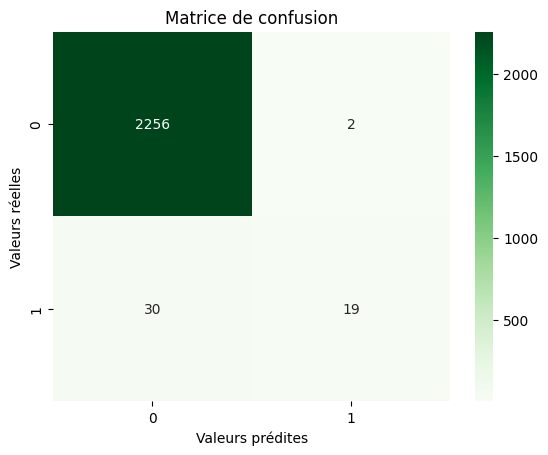

In [ ]:
#Matrice de confusion
cm = confusion_matrix(y_test, y_pred_reg)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

## SVM

In [ ]:
model_svm = SVC()

In [ ]:
model_svm.fit(X_train, y_train)

SVC()

In [ ]:
y_pred_svm = model_svm.predict(X_test)


In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
f1_score_svm = f1_score(y_test, y_pred_svm, average='macro')

In [ ]:
print("Accuracy :", accuracy_svm)
print("Précision :", precision_svm)
print("Recall :", recall_svm)
print("F1 Score :", f1_score_svm)

Accuracy : 0.9913307325530992
Précision : 0.9956101843722563
Recall : 0.7959183673469388
F1 Score : 0.8695902862569529


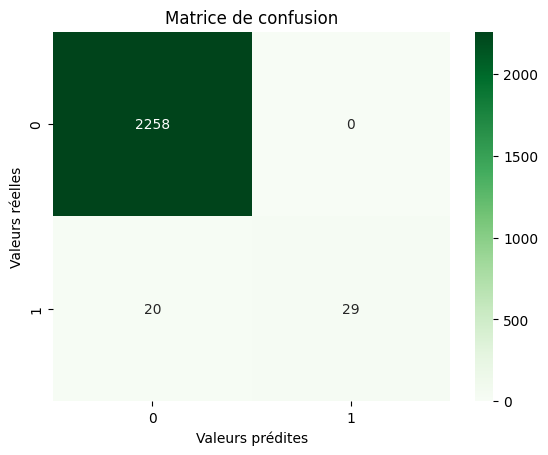

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

## Randomforest

In [ ]:
model_rand = RandomForestClassifier()
model_rand.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_rand = model_rand.predict(X_test)

In [ ]:
accuracy_rand = accuracy_score(y_test, y_pred_rand)
precision_rand = precision_score(y_test, y_pred_rand)
recall_rand = recall_score(y_test, y_pred_rand)
f1_score_reg = f1_score(y_test, y_pred_rand)

In [ ]:
print("Résultats de l'évaluation :")
print("Accuracy :", accuracy_rand)
print("Précision :", precision_rand)
print("Recall :", recall_rand)
print("F1-score :", f1_score_reg)

Résultats de l'évaluation :
Accuracy : 0.9982661465106198
Précision : 1.0
Recall : 0.9183673469387755
F1-score : 0.9574468085106383


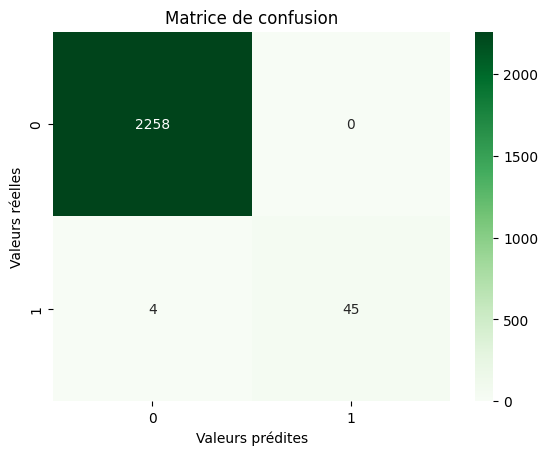

In [ ]:
cm = confusion_matrix(y_test, y_pred_rand)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

## Comparaison

In [ ]:
results = [
    {"Model Sc2": "Logistic Regression", "Accuracy": accuracy_reg, "Precision": precision_reg, "Recall": recall_reg, "F1 Score": f1_score_reg},
    {"Model Sc2": "SVM", "Accuracy": accuracy_svm, "Precision": precision_svm, "Recall": recall_svm, "F1 Score": f1_score_svm},
    {"Model Sc2": "Random Forest", "Accuracy": accuracy_rand, "Precision": precision_rand, "Recall": recall_rand, "F1 Score": f1_score_reg}
]

In [ ]:
tab_comp = pd.DataFrame(results)

In [ ]:
tab_comp

,Model Sc2,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.986129,0.904762,0.387755,0.957447
1,SVM,0.991331,0.995610,0.795918,0.869590
2,Random Forest,0.998266,1.000000,0.918367,0.957447
